In [1]:
# import sys
# sys.path.append('./algorithms/')
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# get RL2 trained policy for example
RUN_FOLDER = './logs/logs_ML10-v2/rl2_73__25:10_21:13:08'
policy_net = torch.load(RUN_FOLDER + '/models/policy.pt')
encoder_net = torch.load(RUN_FOLDER + '/models/encoder.pt')

In [3]:
# from continualworld_utils.wrappers import RandomizationWrapper

TASK_SEQS = {
    "CW10": [
        "hammer-v2",
        "push-wall-v2",
        "faucet-close-v2",
        "push-back-v2",
        "stick-pull-v2",
        "handle-press-side-v2",
        "push-v2",
        "shelf-place-v2",
        "window-close-v2",
        "peg-unplug-side-v2",
    ],
}

TASK_SEQS["CW20"] = TASK_SEQS["CW10"] + TASK_SEQS["CW10"]

In [4]:
from algorithms.custom_storage import CustomOnlineStorage
from algorithms.custom_ppo import CustomPPO
from models.combined_actor_critic import ActorCritic

# num_processes = 4
# combined network with encoder + policy
ac = ActorCritic(policy_net, encoder_net)
agent = CustomPPO(
    actor_critic=ac,
    value_loss_coef = 0.4,
    entropy_coef = 0.001,
    policy_optimiser='adam',
    policy_anneal_lr=False,
    train_steps = 3, # do I even need this?
    lr = 1.0e-5,
    eps=1.0e-8,
    clip_param = 0.2,
    ppo_epoch = 5,
    use_huber_loss = True,
    use_clipped_value_loss=True,
    context_window=None
)

# logger = CustomLogger('test_logs', 'dummy')
# env = training_envs[0]
# env = ContinualEnv(training_envs, 500)
# envs = SubprocVecEnv([make_continual_env('continualMW-v0', **{'envs' : training_envs}) for i in range(num_processes)])


In [5]:
from continualworld_utils.constants import TASK_SEQS
from continuallearner import ContinualLearner
num_processes = 4
steps_per_env = 1000
rollout_len = 500
## effective steps_per_env = num_processes * steps_per_env = 20000

## TODO: make an env creation function?
# envs = SubprocVecEnv([make_continual_env('continualMW-v0', **{'envs' : training_envs, 'steps_per_env': steps_per_env}) for i in range(num_processes)])
# env = PyTorchVecEnvCont(envs, device)
# envs = prepare_parallel_envs(envs, steps_per_env, num_processes, device)

continual_learner = ContinualLearner(
    42,
    TASK_SEQS['CW20'], 
    agent, 
    num_processes, 
    rollout_len,
    steps_per_env,
    # logger,
    'test_logs',
    'dummy',
    log_every = 5
)

Seeding random, torch, numpy.
Note that due to parallel processing results will be similar but not identical. Use only one process and set --deterministic_execution to True if you want identical results (only recommended for debugging).


2024-01-03 12:26:16.673271: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-03 12:26:16.769728: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-03 12:26:16.769742: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-01-03 12:26:17.284147: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

logging under test_logs/dummy__03:01_12:26:16


In [6]:
continual_learner.train()

Evaluating at Episode: 4
eval completed in 47.9515221118927
Evaluating at Episode: 9
eval completed in 47.71731090545654
Evaluating at Episode: 14
eval completed in 47.73053288459778
Evaluating at Episode: 19
eval completed in 47.6690993309021
Evaluating at Episode: 24
eval completed in 48.00946116447449
Evaluating at Episode: 29
eval completed in 47.99937391281128
Evaluating at Episode: 34
eval completed in 47.70044159889221
Evaluating at Episode: 39
eval completed in 47.80504059791565
completed in 1108.1737792491913


In [6]:
continual_learner.env_id_to_name

{1: 'hammer-v2',
 2: 'push-wall-v2',
 3: 'faucet-close-v2',
 4: 'push-back-v2',
 5: 'stick-pull-v2',
 6: 'handle-press-side-v2',
 7: 'push-v2',
 8: 'shelf-place-v2',
 9: 'window-close-v2',
 10: 'peg-unplug-side-v2',
 11: 'hammer-v2',
 12: 'push-wall-v2',
 13: 'faucet-close-v2',
 14: 'push-back-v2',
 15: 'stick-pull-v2',
 16: 'handle-press-side-v2',
 17: 'push-v2',
 18: 'shelf-place-v2',
 19: 'window-close-v2',
 20: 'peg-unplug-side-v2'}

In [10]:
k = torch.load('test_logs/dummy__28:12_14:51:18/actor_critic.pt')

In [54]:

# import seaborn as sns
# new_res = {k:(*res[k][0:5], res[k][-1].cpu().detach().numpy() / 500) for k in res.keys()}
df = pd.DataFrame(res)
df.index = ['value_loss', 'actor_loss', 'entropy_loss', 'total_loss', 'task', 'episode_reward']
df = df.T.reset_index().melt(id_vars = ['task', 'index'])
df.loc[:,'value'] = df.loc[:, 'value'].astype(float)

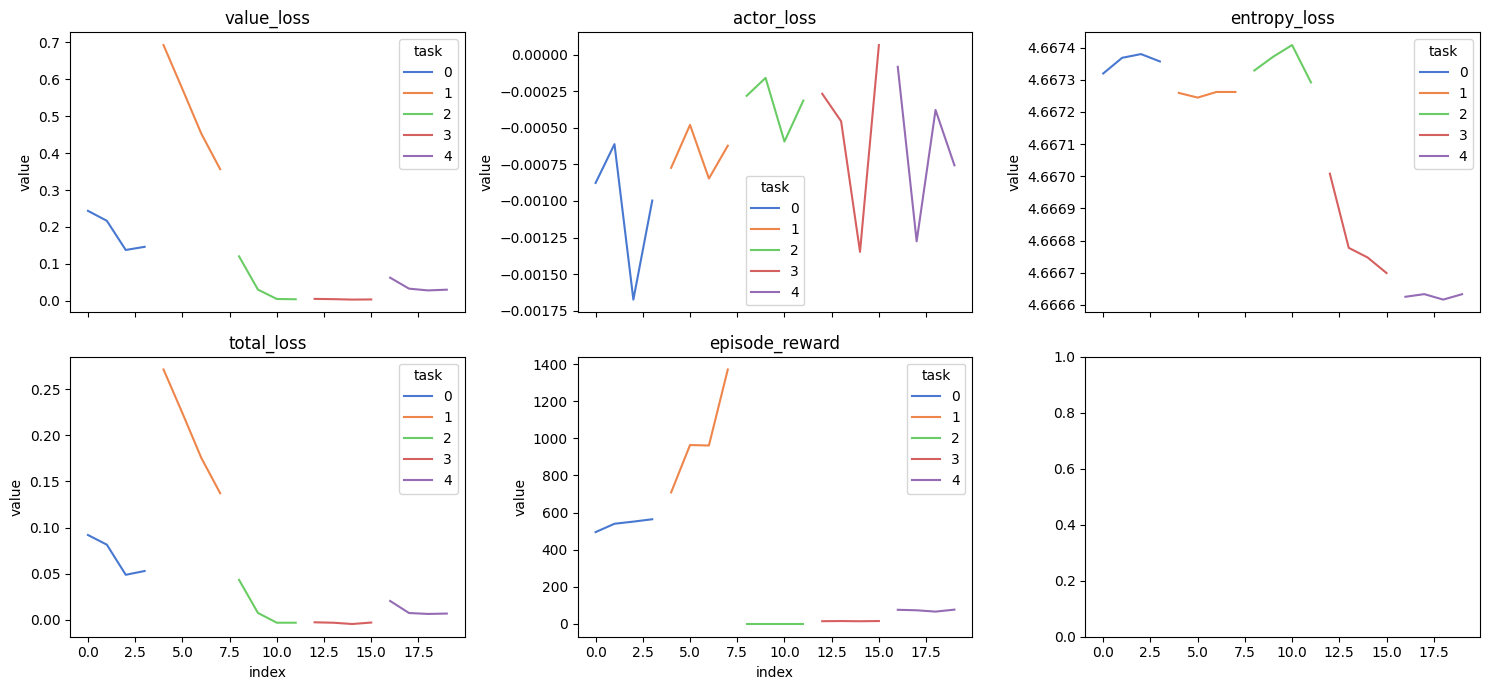

In [55]:


fig, ax = plt.subplots(2,3, figsize = (15, 7), sharex = True)
ax = ax.flatten()
for i, col in enumerate(['value_loss', 'actor_loss', 'entropy_loss', 'total_loss', 'episode_reward']):

    sns.lineplot(
        data = df.query(f"variable=='{col}'"),
        x = 'index',
        y = 'value',
        hue = 'task',
        palette = 'muted',
        ax = ax[i]
        # style='task'
        )
    ax[i].set_title(f'{col}')

plt.tight_layout()
plt.show()

In [9]:
results = pd.read_csv('test_logs/dummy__03:01_12:26:16/results.csv')
results.loc[:,'is_training_task'] = results.loc[:,'training_task'] == results.loc[:,'evaluation_task']
results.head()

,training_task,evaluation_task,num_successes,num_episodes,reward_mean,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9,episode,is_training_task
0,faucet-close-v2,faucet-close-v2,0.0,10,0.741809,0.000000,0.809547,0.812711,0.812731,0.903934,0.953998,0.964633,0.967015,1.006704,4,True
1,faucet-close-v2,hammer-v2,5.0,10,0.594757,0.150183,0.152850,0.187596,0.224075,0.268231,0.304856,0.368702,0.522203,1.095898,4,False
2,faucet-close-v2,handle-press-side-v2,0.0,10,0.004933,0.002715,0.002786,0.002930,0.003799,0.005224,0.005432,0.005524,0.005536,0.006047,4,False
3,faucet-close-v2,peg-unplug-side-v2,0.0,10,0.010737,0.007679,0.008063,0.008786,0.009037,0.009519,0.010399,0.010631,0.011389,0.012634,4,False
4,faucet-close-v2,push-back-v2,0.0,10,0.279216,0.026139,0.048033,0.134401,0.222998,0.291360,0.333712,0.375991,0.423644,0.512935,4,False


In [11]:
results.query('is_training_task')

,training_task,evaluation_task,num_successes,num_episodes,reward_mean,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9,episode,is_training_task
0,faucet-close-v2,faucet-close-v2,0.0,10,0.741809,0.000000,0.809547,0.812711,0.812731,0.903934,0.953998,0.964633,0.967015,1.006704,4,True
18,stick-pull-v2,stick-pull-v2,0.0,10,0.014904,0.002155,0.004000,0.005687,0.006943,0.010620,0.013731,0.014105,0.016108,0.036275,9,True
27,shelf-place-v2,shelf-place-v2,0.0,10,0.010203,0.005734,0.005749,0.006022,0.007035,0.007545,0.007581,0.007624,0.007872,0.008608,14,True
33,peg-unplug-side-v2,peg-unplug-side-v2,0.0,10,0.009631,0.005063,0.007042,0.007671,0.008051,0.008289,0.008763,0.009228,0.010187,0.010216,19,True
40,faucet-close-v2,faucet-close-v2,0.0,10,0.814253,0.693941,0.821994,0.822039,0.872511,0.905767,0.945184,0.966983,0.967037,0.968574,24,True
58,stick-pull-v2,stick-pull-v2,1.0,10,0.069197,0.006634,0.016651,0.021478,0.026157,0.029673,0.040416,0.042266,0.109436,0.184704,29,True
67,shelf-place-v2,shelf-place-v2,0.0,10,0.010610,0.005737,0.006010,0.006088,0.006708,0.007570,0.008015,0.008138,0.008817,0.009927,34,True
73,peg-unplug-side-v2,peg-unplug-side-v2,0.0,10,0.011724,0.004373,0.008252,0.008681,0.009149,0.009863,0.011139,0.012380,0.013588,0.015978,39,True


<Axes: xlabel='episode', ylabel='reward_mean'>

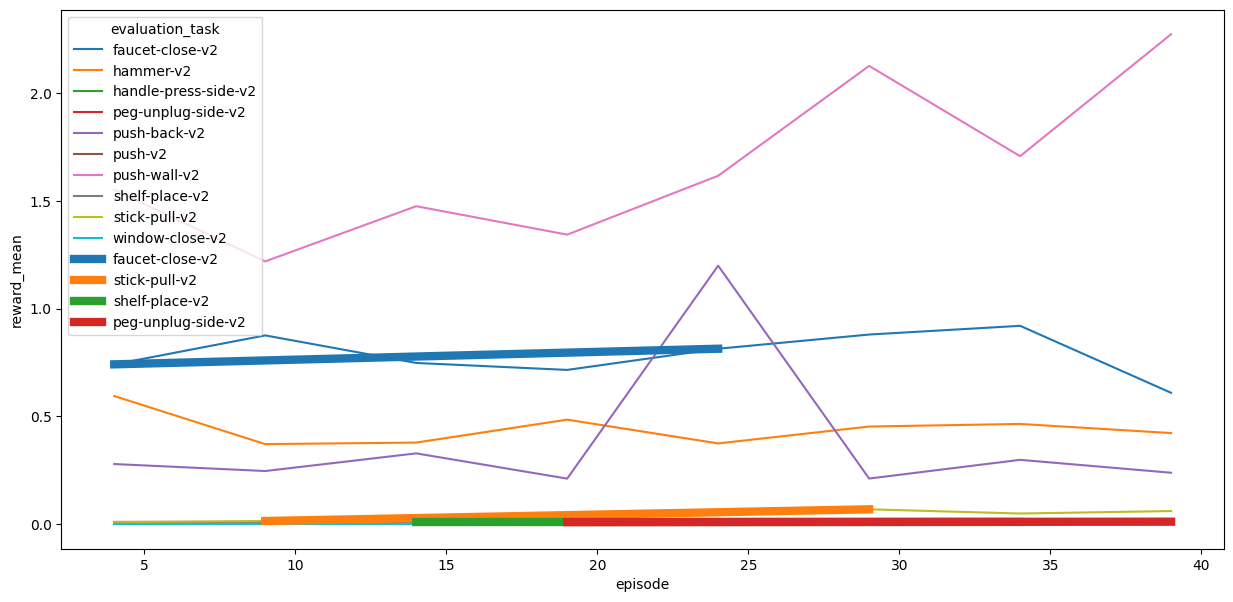

In [10]:
fig, ax = plt.subplots(figsize = (15, 7))
sns.lineplot(
    data = results,
    x = 'episode',
    y = 'reward_mean',
    hue = 'evaluation_task'
)

sns.lineplot(
    data = results.query('training_task==evaluation_task'),
    x = 'episode',
    y = 'reward_mean',
    hue='evaluation_task',
    linewidth = 6
)

<Axes: xlabel='episode', ylabel='num_successes'>

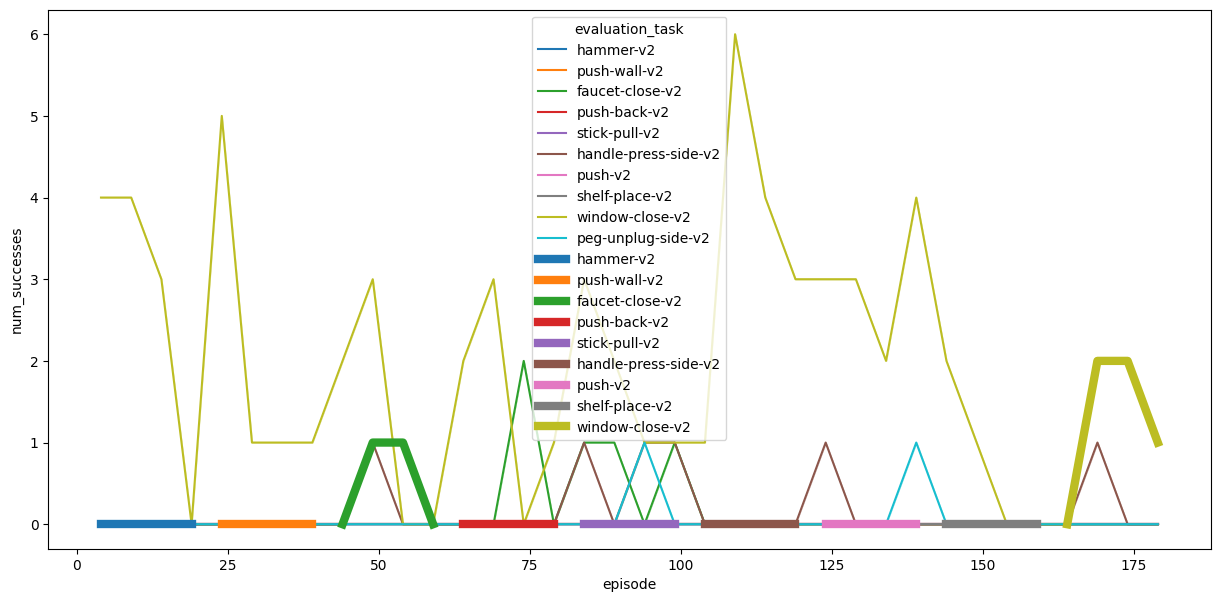

In [28]:
fig, ax = plt.subplots(figsize = (15, 7))
sns.lineplot(
    data = results,
    x = 'episode',
    y = 'num_successes',
    hue = 'evaluation_task'
)

sns.lineplot(
    data = results.query('training_task==evaluation_task'),
    x = 'episode',
    y = 'num_successes',
    hue='evaluation_task',
    linewidth = 6
)

In [9]:
results.query('is_training_task')

,training_task,evaluation_task,num_successes,num_episodes,reward_mean,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9,episode,is_training_task
0,hammer-v2,hammer-v2,0.0,10,0.910598,0.780283,0.789160,0.803924,0.817050,0.851817,0.898622,0.974819,1.123456,1.129701,4,True
10,hammer-v2,hammer-v2,0.0,10,0.910598,0.780283,0.789160,0.803924,0.817050,0.851817,0.898622,0.974819,1.123456,1.129701,4,True
20,hammer-v2,hammer-v2,0.0,10,0.878062,0.730936,0.832336,0.893207,0.893235,0.912812,0.960320,1.113591,1.123449,1.129700,9,True
30,hammer-v2,hammer-v2,0.0,10,0.878062,0.730936,0.832336,0.893207,0.893235,0.912812,0.960320,1.113591,1.123449,1.129700,9,True
40,hammer-v2,hammer-v2,0.0,10,1.022165,0.800213,0.949302,1.076146,1.076167,1.076173,1.081571,1.113594,1.123446,1.123457,14,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,window-close-v2,window-close-v2,2.0,10,0.501695,0.149139,0.151781,0.170277,0.217943,0.262141,0.304021,0.377562,0.549127,0.709967,169,True
688,window-close-v2,window-close-v2,2.0,10,0.448027,0.145816,0.151005,0.152370,0.159697,0.190677,0.223824,0.266132,0.338446,0.636508,174,True
698,window-close-v2,window-close-v2,2.0,10,0.448027,0.145816,0.151005,0.152370,0.159697,0.190677,0.223824,0.266132,0.338446,0.636508,174,True
708,window-close-v2,window-close-v2,1.0,10,0.293168,0.144509,0.148977,0.151165,0.152732,0.155891,0.169647,0.210269,0.292666,0.488839,179,True


In [10]:
results

,training_task,evaluation_task,num_successes,num_episodes,reward_mean,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9,episode,is_training_task
0,hammer-v2,hammer-v2,0.0,10,0.910598,0.780283,0.789160,0.803924,0.817050,0.851817,0.898622,0.974819,1.123456,1.129701,4,True
1,hammer-v2,push-wall-v2,0.0,10,0.009346,0.005741,0.005753,0.005761,0.005822,0.005898,0.005923,0.006167,0.008424,0.008571,4,False
2,hammer-v2,faucet-close-v2,0.0,10,1.389136,0.489203,0.514976,0.546635,0.585126,0.808138,1.536218,2.154801,2.396594,2.887884,4,False
3,hammer-v2,push-back-v2,0.0,10,0.003783,0.002627,0.002632,0.002675,0.002827,0.002896,0.003157,0.003304,0.003895,0.004968,4,False
4,hammer-v2,stick-pull-v2,0.0,10,0.009642,0.007244,0.007397,0.007602,0.008294,0.009071,0.009247,0.009284,0.009838,0.011112,4,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,window-close-v2,handle-press-side-v2,0.0,10,0.374043,0.123859,0.157703,0.197693,0.265653,0.311627,0.369620,0.442578,0.529147,0.728904,179,False
716,window-close-v2,push-v2,0.0,10,0.010096,0.005860,0.005885,0.006275,0.006504,0.006537,0.007363,0.008113,0.011262,0.012880,179,False
717,window-close-v2,shelf-place-v2,0.0,10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,179,False
718,window-close-v2,window-close-v2,1.0,10,0.293168,0.144509,0.148977,0.151165,0.152732,0.155891,0.169647,0.210269,0.292666,0.488839,179,True


In [15]:
results.training_task

0            hammer-v2
1            hammer-v2
2            hammer-v2
3            hammer-v2
4            hammer-v2
            ...       
715    window-close-v2
716    window-close-v2
717    window-close-v2
718    window-close-v2
719    window-close-v2
Name: training_task, Length: 720, dtype: object

In [22]:
average_performance_df = results\
    .groupby(['episode', 'training_task'])\
    .agg({'reward_mean': 'mean', 'num_successes': 'mean'})\
    .reset_index()
average_performance_df

,episode,training_task,reward_mean,num_successes
0,4,hammer-v2,0.306701,0.4
1,9,hammer-v2,0.313565,0.4
2,14,hammer-v2,0.338779,0.3
3,19,hammer-v2,0.310690,0.0
4,24,push-wall-v2,0.367682,0.5
5,29,push-wall-v2,0.341313,0.1
6,34,push-wall-v2,0.330136,0.1
7,39,push-wall-v2,0.356731,0.1
8,44,faucet-close-v2,0.389015,0.2
9,49,faucet-close-v2,0.481074,0.5


<Axes: xlabel='episode', ylabel='num_successes'>

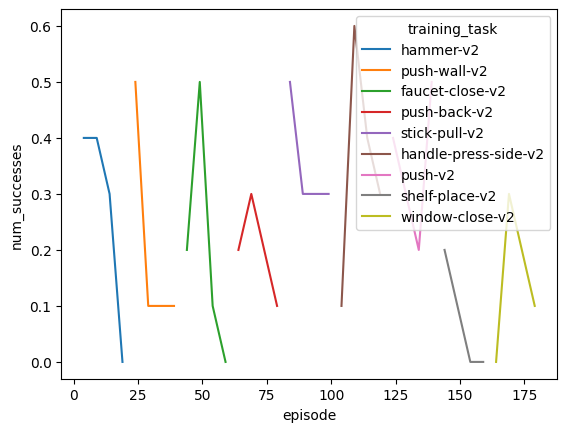

In [23]:
## try calculating metrics
## 1. average performance
## instead, lets count successes, and save number of episodes - then we calculate avg success
# average_performance_df = results\
#     .groupby('episode')\
#     .agg({'reward_mean': 'mean', 'num_successes':lambda x: x.num_successes})\
#     .reset_index()

sns.lineplot(
    data = average_performance_df,
    x = 'episode',
    y = 'num_successes',
    hue = 'training_task'
)

In [ ]:
## 2. Forward transfer
# look at CORA

In [ ]:
## 3. Forgetting
# success rate during training vs success rate at end
# need to calculate cumulative success rate

In [7]:
num_processes = 4
steps_per_env = 4000
rollout_len = 1000

print(
    steps_per_env % num_processes * rollout_len == 0,
    steps_per_env - num_processes * rollout_len >= 0
    )

True True


In [12]:
envs = prepare_parallel_envs(training_envs, steps_per_env, num_processes, device)
obs = envs.reset()
with torch.no_grad():
    _, latent_mean, latent_logvar, hidden_state = agent.actor_critic.encoder.prior(num_processes)

    ## TODO: set the 500 to some sort of variable (max episode len?)
    # assert len(storage.latent) == 0  # make sure we emptied buffers
    # print(f"saving hidden state to {i * 500}")

    latent = torch.cat((latent_mean.clone(), latent_logvar.clone()), dim=-1)#.reshape(1, -1)



value, action = agent.act(obs, latent, None, None)
next_obs, reward, done, info = envs.step(action)

value, action = agent.act(obs, latent, None, None)
next_obs, reward2, done, info2 = envs.step(action)

In [13]:
successes = []
successes.append(torch.tensor([i['success'] for i in info]))
successes.append(torch.tensor([i['success'] for i in info2]))

In [22]:
torch.stack(successes).max(0)[0].sum() / num_processes

tensor(0.)

: 

In [41]:
num_processes = 4
steps_per_env = 2000
rollout_len = 500
## effective steps_per_env = num_processes * steps_per_env = 8000
envs = SubprocVecEnv([make_continual_env('continualMW-v0', **{'envs' : training_envs, 'steps_per_env': steps_per_env}) for i in range(num_processes)])
env = PyTorchVecEnvCont(envs, device)
storage = CustomOnlineStorage(
    rollout_len, num_processes, env.observation_space.shape[0]+1, 0, 0,
    env.action_space, ac.encoder.hidden_size, ac.encoder.latent_dim, False)
res = dict()
eps = 0
while env.get_env_attr('cur_step') < env.get_env_attr('steps_limit'):
    print(f"current step: {env.get_env_attr('cur_step')}; limit: {env.get_env_attr('steps_limit')}")
    step = 0

    
    # if I do this, I need to make sure my returns are calculated correctly / the done flags work
    # for i in range(num_episodes_per_update):
    obs = env.reset()
    current_task = env.get_env_attr("cur_seq_idx")
    episode_reward = 0
    done = [False for _ in range(num_processes)]
    # print(f"running episode {i}")
    ## get prior??? how frequent?
    # do at start of each episode for now
    with torch.no_grad():
        _, latent_mean, latent_logvar, hidden_state = agent.actor_critic.encoder.prior(num_processes)
        print(step)
        ## TODO: set the 500 to some sort of variable (max episode len?)
        assert len(storage.latent) == 0  # make sure we emptied buffers
        # print(f"saving hidden state to {i * 500}")
        storage.hidden_states[:1].copy_(hidden_state)
        latent = torch.cat((latent_mean.clone(), latent_logvar.clone()), dim=-1)#.reshape(1, -1)
        storage.latent.append(latent)

    while not all(done):
        value, action = agent.act(obs, latent, None, None)
        next_obs, reward, done, info = env.step(action)
        assert all(done) == any(done), "Metaworld envs should all end simultaneously"

        obs = next_obs
        episode_reward += reward.sum() / num_processes

        ## TODO: do I even need masks?
        # create mask for episode ends
        masks_done = torch.FloatTensor([[0.0] if _done else [1.0] for _done in done]).to(device)
        # bad_mask is true if episode ended because time limit was reached
        # don't care for metaworld
        bad_masks = torch.FloatTensor([[0.0] for _done in done]).to(device)

        # if done:
        #     print(f'{step}: done!')
        #     hidden_state = agent.actor_critic.encoder.reset_hidden(hidden_state, masks_done)
        # print(action.size(), obs.squeeze(0).size(), reward.squeeze(0).size(), hidden_state.size(), latent.size(), masks_done.size(), bad_masks.size())
        _, latent_mean, latent_logvar, hidden_state = agent.actor_critic.encoder(action, obs, reward, hidden_state, return_prior = False)
        latent = torch.cat((latent_mean.clone(), latent_logvar.clone()), dim = -1)[None,:]#.reshape(1, -1)

        
        storage.next_state[step] = obs.clone()
        # print(action.squeeze(0).size(), obs.squeeze(0).size(), reward.squeeze(0).size(), hidden_state.size(), latent.size(), masks_done.size(), bad_masks.size())
        storage.insert(
            state=obs.squeeze(),
            belief=None,
            task=None,
            actions=action.double(),
            rewards_raw=reward.squeeze(0),
            rewards_normalised=reward.squeeze(0),#rew_normalised, don't use
            value_preds=value.squeeze(0),
            masks=masks_done.squeeze(0), # do I even need these?
            bad_masks=bad_masks.squeeze(0), 
            done=torch.from_numpy(done)[:,None].float(),
            hidden_states = hidden_state.squeeze(),
            latent = latent#.unsqueeze(1),
        )

        step += 1
        ### update
        # if step % num_updates ==0:

    # update at the end of each episode?
    res[eps] = (*agent.update(storage), current_task, episode_reward.cpu().detach().numpy())

    # # # should clear out old data
    storage.after_update()
    # update total steps
    # env.__setattr__('cur_step',  num_processes * rollout_len)
    eps+=1
    
        




current step: 0; limit: 10000
0
current step: 500; limit: 10000
0
current step: 1000; limit: 10000
0
current step: 1500; limit: 10000
0
current step: 2000; limit: 10000
0
current step: 2500; limit: 10000
0
current step: 3000; limit: 10000
0
current step: 3500; limit: 10000
0
current step: 4000; limit: 10000
0
current step: 4500; limit: 10000
0
current step: 5000; limit: 10000
0
current step: 5500; limit: 10000
0
current step: 6000; limit: 10000
0
current step: 6500; limit: 10000
0
current step: 7000; limit: 10000
0
current step: 7500; limit: 10000
0
current step: 8000; limit: 10000
0
current step: 8500; limit: 10000
0
current step: 9000; limit: 10000
0
current step: 9500; limit: 10000
0


In [50]:
import pandas as pd
# import seaborn as sns
new_res = {k:(*res[k][0:5], res[k][-1].cpu().detach().numpy() / 500) for k in res.keys()}
df = pd.DataFrame(new_res)
df.index = ['value_loss', 'actor_loss', 'entropy_loss', 'total_loss', 'task', 'episode_reward']
df.T.reset_index().melt(id_vars = ['task', 'index'])
# df.T.plot()

,task,index,variable,value
0,0.0,0,value_loss,0.237375
1,0.0,1,value_loss,0.238127
2,0.0,2,value_loss,0.270180
3,0.0,3,value_loss,0.173969
4,1.0,4,value_loss,0.746167
...,...,...,...,...
95,3.0,15,episode_reward,0.021147
96,4.0,16,episode_reward,0.135644
97,4.0,17,episode_reward,0.117424
98,4.0,18,episode_reward,0.146787


<Axes: xlabel='index', ylabel='value'>

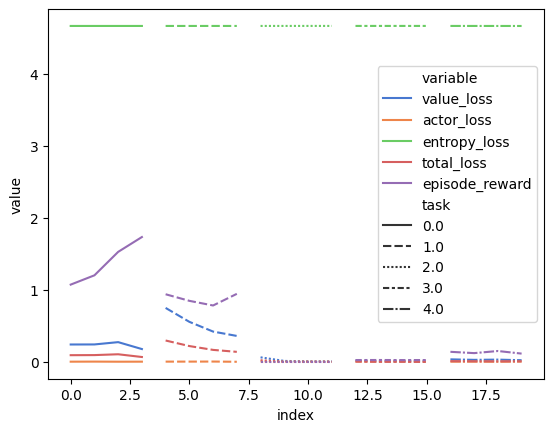

In [54]:
import seaborn as sns

sns.lineplot(
    data = df.T.reset_index().melt(id_vars = ['task', 'index']),
    x = 'index',
    y = 'value',
    hue = 'variable',
    palette = 'muted',
    style='task'


)